# 05. Parameter Identifiability - Profile Likelihoods

This notebook demonstrates how to evaluate parameter identifiability and to derive Confidence Intervals using profile likleihoods, a technique to analyse structural and practical identifiability of model parameters. In `estim8`, this procedure samples the likelihood profile of a parameter of interest by fixing it at certain values and then re-estimating the remaining free parameters.

For the interested reader the following references provide an in-depth discussion of the method:
- [A. Raue, C. Kreutz, T. Maiwald, J. Bachmann, M. Schilling, U. Klingmüller, J. Timmer, Structural and practical identifiability analysis of partially observed dynamical models by exploiting the profile likelihood, Bioinformatics, Volume 25, Issue 15, August 2009, Pages 1923–1929, https://doi.org/10.1093/bioinformatics/btp358](https://academic.oup.com/bioinformatics/article/25/15/1923/213246)
- [Kreutz C, Raue A, Kaschek D, Timmer J. Profile likelihood in systems biology. FEBS J. 2013 Jun;280(11):2564-71. doi: 10.1111/febs.12276. Epub 2013 May 9. PMID: 23581573.](https://febs.onlinelibrary.wiley.com/doi/10.1111/febs.12276)

### Imports

In [1]:
import sys 
sys.path.append(r'..')

from estim8.models import FmuModel
from estim8 import visualization, datatypes, Estimator
from estim8.error_models import LinearErrorModel
from estim8.profile import approximate_confidence_interval, calculate_negll_thresshold
import pandas as pd
import matplotlib.pyplot as plt

## 6.1 Load the model 

For demonstration purpose, the `SimpleBatch` model introduced in [Notebook 1. Modeling & Simulation](1.%20Modeling%20&%20Simulation.ipynb) is used.

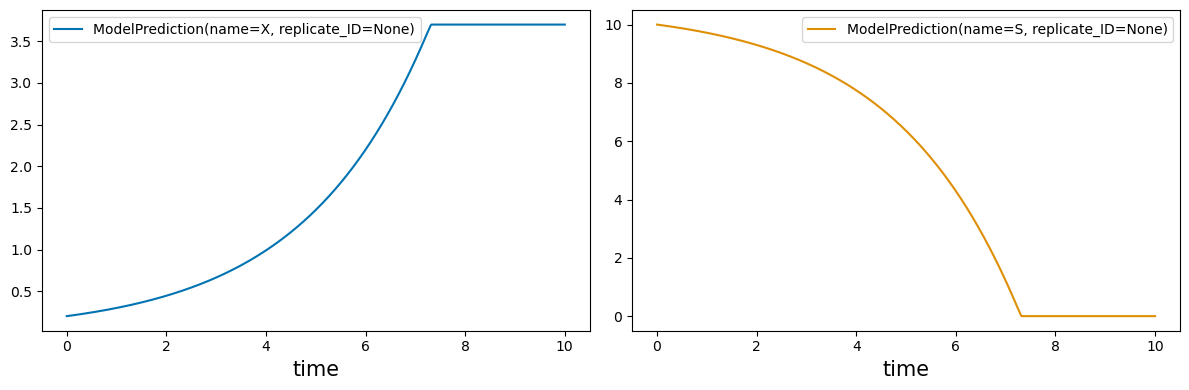

In [2]:
SimpleBatchModel = FmuModel(path='../tests/test_data/SimpleBatch.fmu')

# run a simulation with default parameters
simulation = SimpleBatchModel.simulate(t0=0, t_end=10, stepsize=1e-3, observe=["X", "S"])
_ = visualization.plot_simulation(simulation)

## 6.2 Import experimental data

The profile likelihood method translates the uncertainty in experimental data to model parameters. It is therefore a _likleihood-driven_ techniqe which requires to model the data with some sorft of probability distribution. In this example and in many real world problems, the measurement noise is assumed to be normally distributed, which is the default model in `estim8`'s `LinearErrorModel`:

In [3]:
data = pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0, header=(0, 1))
data.columns = data.columns.droplevel(1)
data.head()

# assume a linear error model with relative error (scale) of 5% and an absolute error (offset) of 0.01
error_model = LinearErrorModel(
    slope=0.05,
    offset=0.01,
    )
# print the error models error distribution
print(error_model.error_distribution.__class__)

# create an experiment object
experiment = datatypes.Experiment(
    measurements=data,
    error_model=error_model,
    )

<class 'scipy.stats._continuous_distns.norm_gen'>


## 6.3 Defining the estimation problem & create `Estimator` object

Like in [Notebook 3. Parameter estimation](3.%20Parameter%20estimation.ipynb), the estimation problem is defined with unknown model parameters and their bounds. The `Estimator` class then serves as a central hub to collect all inputs and to manage parameter estimations.

In [4]:
## define unknown parameters with upper and lower bounds
bounds = {
    'X0': [0.05, 0.15],
    'mu_max': [0.1, 0.9],
    'Y_XS': [0.1, 1]
}

estimator = Estimator(
    model=SimpleBatchModel,
    bounds=bounds,
    data=experiment,
    t=[0, 10, 0.1],
    metric="negLL"      # use tthe negative log likelihood as the objective function
)

## 6.4 Find the Optimum

The `estimate` method is then used to obtain point estimators.

c:\Users\Latour\AppData\Local\miniforge3\envs\testim8\Lib\site-packages\scipy\optimize\_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


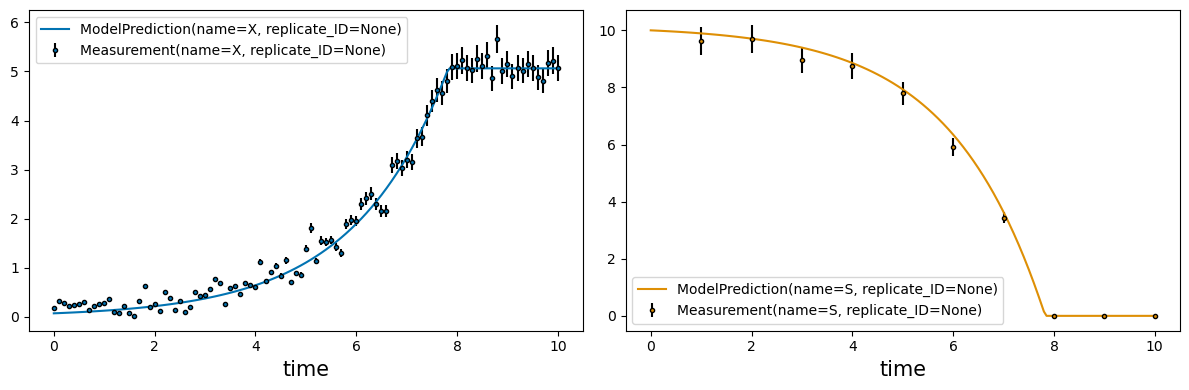

In [5]:
estimates, est_info = estimator.estimate(
    method='de',
    max_iter=1000,
    n_jobs=4,
    optimizer_kwargs={
        "tol": 1e-3
    }
)

_ = visualization.plot_estimates(estimator=estimator, estimates=estimates, only_measured=True)

## 6.5 Profile Likelihood Calculation

The `Estimator`'s `profile_likelihood` function is then used to sample the profiles likelihoods using a sampler with a fixed `stepsize` in descending/ascending direction from the estimated optimum for each parameter of interest. As this is a technique based on re-estimation, the same arguments for a single parameter estimation task described in [Notebook 3. Parameter estimation](3.%20Parameter%20estimation.ipynb) can be used. The function takes at least the following arguments:

| Arg | Type | Description |
|:----------|:-----|:------------|
| p_opt | dict | The estimated optimal parameters |
| method | str \| List[str] | The optimization method(s) to use for each estimation job|
| max_iter | int | Maximum number of iterations for each optimization |
| n_jobs | int | Parallelization of each individual estimation |

Key-word arguments comprise:

| Kwarg | Type | Description |
|:----------|:-----|:------------|
| optimizer_kwargs | dict | Additional arguments passed to the optimization function |
| p_at_once | int | Number of parallel profile samplers at once. Default is 1|
| alpha | float | Confidence level of the profile likleihood, default is 0.05. |
| max_points | int | Maximum number of grid points to evaluate per parameter and direction. Default is `None`, in which case each sampler proceeds until a negLL threshold based upon a $\chi^2$ quantile given `alpha` is reached. |
| stepsize | float | Relative parameter variation stepsize (between 0 and 1) for each parameter, default is 0.02|
| p_inv | list | List of parameters to investigate (defaults to all parameters in p_opt) |

⚠️ This method puts considerable amount of work on your machine!

In [6]:
pl_result = estimator.profile_likelihood(
    p_opt= estimates,
    # arguments for each estimation procedure    
    method='de',
    optimizer_kwargs={
        "tol": 1e-3
    },        
    max_iter=1000,       
    n_jobs=1,
    # profiling arguments           
    p_at_once=6,         
    stepsize=0.006,      
)

## 6.6 Evaluation of profile likelihoods

### 6.6.1 Parameter identifiability

Generally, profile likelihoods can reveal the three different scenarious shown in the figure below. 

- _Structural non-identifiability_ of a parameter results in a flat likelihood profile
- _Pracical non-identifiablity_, meaning the parameter is not identifiable given the data is given if the likelihood profile does not completely pass the confidence threshold.
- For a structural and practical _identifiable_ parameter the profile likleihood exceeds the threshold in both directions.


![](../docs/source/images/profile_likelihood_identifiability_cases.png)


The results of the `profile_likelihood` function can be shown using the `plot_profile_likelihood` function from the `visualization` submodule.

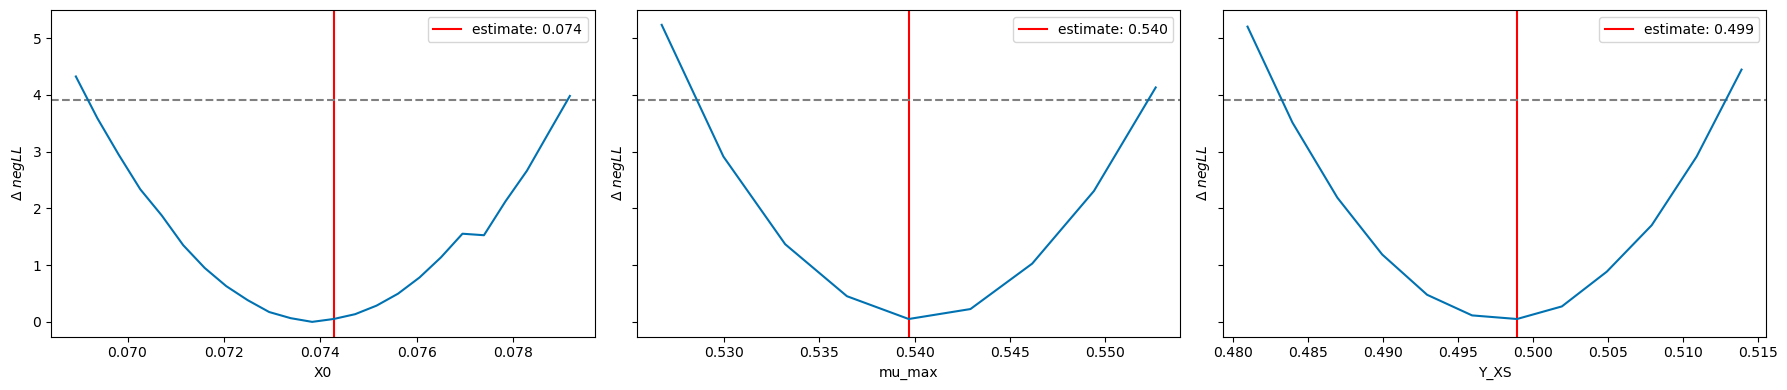

In [7]:
_ = visualization.plot_profile_likelihood(pl_result, estimates, show_coi=False)

### 6.6.2 Profile likelihood based Confidence Intervals

Given enough datapoints in the profile likelihoods, the results can be used to derive confidence intervals for the estimated parameters. The `plot_profile_likelihood` function can be called with `show_coi=True` to display likelihood based confidence intervals given a confidence level `alpha`.

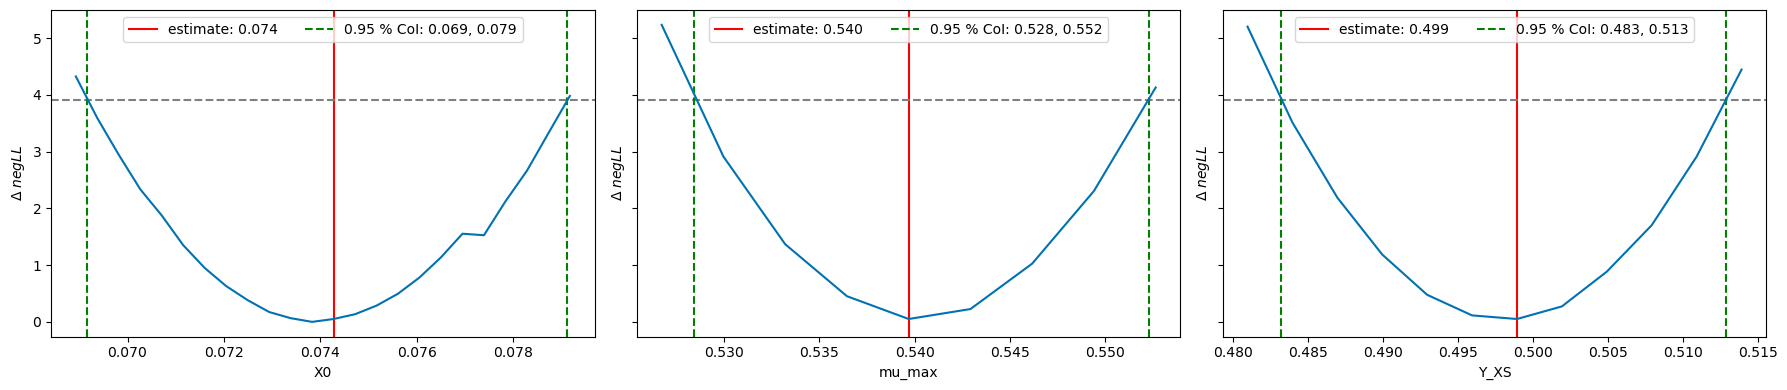

In [8]:
_ = visualization.plot_profile_likelihood(pl_result, estimates,  alpha=0.05, show_coi=True)

Additionally, `estim8` provides functions for calculating confidence intervals.

In [9]:
alpha = 0.05
threshold = calculate_negll_thresshold(alpha=alpha, df=len(estimates), mle_negll=est_info["fun"])

for parameter, pl in pl_result.items():
    par_values = pl[:,0]
    neglls = pl[:,1]
    coi = approximate_confidence_interval(par_values, neglls, threshold)
    print(f"{1-alpha} % Confidence interval for {parameter}: {coi}")

0.95 % Confidence interval for X0: (0.06913299729362944, 0.07915730866720107)
0.95 % Confidence interval for mu_max: (0.5283473082934588, 0.552359558967311)
0.95 % Confidence interval for Y_XS: (0.4830784248423862, 0.5129752888375013)
